<div style="background-color: lightgreen; border-radius: 5px; padding: 10px;">
    <h4>Topic Modeling</h4>
    <p>...</p>
</div>

In [1]:
import os
import pandas as pd
import numpy as np
from ast import literal_eval
from tqdm.notebook import tqdm

from preprocessing_functions import *
from topic_modeling_functions import *

import warnings
warnings.filterwarnings('ignore')

# Train_lda_model
from gensim.models.wrappers import LdaMallet

# Calculate_coherence_score
from gensim.models import CoherenceModel

# Saving and visualising lda models
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

C:\Users\diede\Personal Files [Local]\Applied Data Science\Thesis - CITYNET\venv_citynet3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## 0. Variables

In [11]:
files_dir = '../../../../data_clean/paragraphs_lemmatised/'
# os.listdir('../../../../data_clean/lda_models/')
lda_models_path = '../../../../data_clean/lda_models/'

POS = ["NOUN", "VERB", "ADJ"]
ONLY_ENGLISH_WORDS = True
merged_POS = True
saving = True

# Don't change!
word_type = 'english_words' if ONLY_ENGLISH_WORDS else 'dirty_words'
files_output_dir = f"{files_dir}/{word_type}_merged_{''.join(POS)}"

In [47]:
os.makedirs(f"{files_dir}/merged_{''.join(POS)}", exist_ok=True)

### Merge POS (Should be removed to pre-processing notebook!)

In [72]:
# for file in os.listdir()
preprocessing_notebook = False
if preprocessing_notebook:
    for file in os.listdir(files_dir)[:]:
        if file.endswith(".csv"):

            output_fp = os.path.join(files_output_dir, file.replace('preprocessed', 'merged_POS'))

            if os.path.isfile(output_fp):
                print(f"{output_fp} already exists.")
                continue

            fp = os.path.join(files_dir, file)
            temp_df = pd.read_csv(fp)

            if merged_POS:
                os.makedirs(files_output_dir, exist_ok=True)
                temp_df['merged_POS'] = [[] for _ in range(temp_df.shape[0])]

            for tag in POS:
                if ONLY_ENGLISH_WORDS:
                            column_name = f'{tag}_clean'   
                else:
                    column_name = f'{tag}'

                string_to_list = temp_df[column_name].apply(literal_eval)

                if merged_POS:
                    temp_df['merged_POS'] += string_to_list

            # Save df
            temp_df = temp_df[['city_1', 'city_2', 'paragraph_id', 'paragraph', 'article_id', 'title', 'merged_POS']]
            temp_df.to_csv(output_fp, index=False)

../../../../data_clean/paragraphs_lemmatised//english_words_merged_NOUNVERBADJ\paragraphs_10_934384_1038204_merged_POS.csv already exists.
../../../../data_clean/paragraphs_lemmatised//english_words_merged_NOUNVERBADJ\paragraphs_11_1038204_1142024_merged_POS.csv already exists.
../../../../data_clean/paragraphs_lemmatised//english_words_merged_NOUNVERBADJ\paragraphs_12_1142024_1245844_merged_POS.csv already exists.


In [73]:
temp_df[['city_1', 'city_2', 'paragraph_id', 'paragraph', 'article_id', 'title', 'merged_POS']].head(5)

,city_1,city_2,paragraph_id,paragraph,article_id,title,merged_POS
0,Paris,London,830565,Piip was a member of the Estonian Province Ass...,11414959,Ants Piip,"[member, member, member, delegation, peace, ne..."
1,London,Paris,830566,Piip was a member of the Estonian Province Ass...,11414959,Ants Piip,"[member, member, member, delegation, peace, ne..."
2,Paris,Munich,830567,"Humphrey was born in Saint John, New Brunswick...",11415024,Jack Humphrey,"[school, student, school, bear, study, travel,..."
3,Munich,Paris,830568,"Humphrey was born in Saint John, New Brunswick...",11415024,Jack Humphrey,"[school, student, school, bear, study, travel,..."
4,Turin,Bologna,830569,"Born in Bologna, at the age of 15, he began tr...",11415085,Giuseppe Pedretti,"[age, opposition, family, son, studio, bear, b..."


## 1. Import and merge csv files into a Dataframe

In [3]:
dataframes = []

for file in tqdm(os.listdir(files_output_dir)):
    fp = os.path.join(files_output_dir, file)
    
    temp_df = pd.read_csv(fp)
    dataframes.append(temp_df)
    
len(dataframes)

  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
# frames = [citypair['lemmatized_paragraphs'] for citypair in data_list]
# citypairs = [citypair['city_pair'] for citypair in data_list]

result = pd.concat(dataframes) #, keys=citypairs)
result.set_index('paragraph_id', inplace=True)
result.sort_index(inplace=True)
result.reset_index(inplace=True)

# paris_london = result.loc["paris_london"]
# paris_london.set_index('paragraph_id', inplace=True)
# paris_london

result #.iloc[21051]

,city_1,city_2,paragraph,article_id,title,merged_POS
paragraph_id,,,,,,
1,Birmingham,Florence,The first community of adherents of the Baha'i...,303,Alabama,"['community', 'adherent', 'center', 'found', '..."
2,Florence,Birmingham,The first community of adherents of the Baha'i...,303,Alabama,"['community', 'adherent', 'center', 'found', '..."
3,Paris,London,A major revision of the work by composer and a...,309,An American in Paris,"['revision', 'work', 'composer', 'arranger', '..."
4,London,Paris,A major revision of the work by composer and a...,309,An American in Paris,"['revision', 'work', 'composer', 'arranger', '..."
5,Madrid,Rome,Access to biocapacity in Algeria is lower than...,358,Algeria,"['access', 'world', 'hectare', 'person', 'terr..."
...,...,...,...,...,...,...
2076400,Paris,Stockholm,Mundhir participated in Arab and international...,70585176,Mundhir Masri,"['festival', 'seminar', 'guest', 'participate'..."
2076401,London,Paris,Mundhir participated in Arab and international...,70585176,Mundhir Masri,"['festival', 'seminar', 'guest', 'participate'..."
2076402,London,Stockholm,Mundhir participated in Arab and international...,70585176,Mundhir Masri,"['festival', 'seminar', 'guest', 'participate'..."


## 2. Vectorize data

In [10]:
%%time

result.merged_POS =  result.merged_POS.apply(literal_eval)

CPU times: total: 2min 30s
Wall time: 8min 22s


In [11]:
%%time

paragraphs = result.merged_POS
MIN_DF = 0.1
MAX_DF = 0.8

# Vectorization
dictionary, corpus = vectorize(paragraphs, MIN_DF=MIN_DF, MAX_DF=MAX_DF)

CPU times: total: 2min 48s
Wall time: 15min 41s


## 3.1 Train Single LDA Model

In [13]:
def train_lda_model(lemmatized_text, dictionary=[], corpus=[], MIN_DF = 0.05, MAX_DF = 0.9, N_TOPICS = 10, N_ITERATIONS = 1000, PATH_TO_MALLET=r'C:/mallet/bin/mallet.bat', GET_COHERENCE_SCORE=True, COHERENCE='c_v'):
    """
    --> function that trains model.

        Parameters:
        -----------
            lemmatized_text: list, str -> contains the key words to be matched (created with the lemmatization function)
            dictionary: gensim.corpora.dictionary.Dictionary -> output from vectorization function
            corpus: list ([dictionary.doc2bow(text)...) -> output from vectorization function
            MIN_DF: int (default = 1) -> minimum document frequency
            MAX_DF: int (default = 0.6) -> maximum document frequency
            N_TOPICS: int (default = 10) -> Topics to detect
            N_ITERATIONS: int (default = 1000) -> 1000 often enough
            PATH_TO_MALLET: str (default = 'C:/mallet/bin/mallet.bat') -> location of your mallet execution file
            GET_COHERENCE_SCORE: Bool (default = True) -> Whether the coherence should be calculated
            COHERENCE: Str ( default = 'c_v') -> ..

    """

    # Call vectorization function if either dictionary or corpus is missing as parameter
    if not type(dictionary) == gensim.corpora.dictionary.Dictionary or not corpus:
        dictionary, corpus = vectorize(lemmatized_text, MIN_DF, MAX_DF)

    print(f"topics: {N_TOPICS}, MIN_DF: {MIN_DF}, MAX_DF: {MAX_DF}")

    lda_model = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                # alpha=auto,
                optimize_interval=10,
                iterations=N_ITERATIONS)
    

    output = {'lda_model': lda_model, 'coherence_score': None, 'dictionary': dictionary, 'corpus': corpus}

    if GET_COHERENCE_SCORE:
        output['coherence_score'] = calculate_coherence_score(MODEL=lda_model, LEMMATIZED_TEXT=lemmatized_text, DICTIONARY=dictionary, COHERENCE=COHERENCE)

    return(output)

def calculate_coherence_score(MODEL, LEMMATIZED_TEXT, DICTIONARY, COHERENCE='c_v'):
    """
    --> function that calculates the coherence score of an LDA model.

        Parameters:
        -----------
            MODEL: LdaMallet -> LDA model to save
            LEMMATIZED_TEXT: list -> lemmatised documents
            DICTIONARY: gensim.corpora.dictionary.Dictionary -> Dictionary
            MIN_DF: int (default = 1) -> minimum document frequency
            MAX_DF: int (default = 0.6) -> maximum document frequency

    """
    coherence_score = CoherenceModel(model=MODEL, texts=LEMMATIZED_TEXT, dictionary=DICTIONARY, coherence=COHERENCE).get_coherence()
    return coherence_score

In [14]:
%%time

# result.merged_POS =  result.merged_POS.apply(literal_eval)

# paragraphs = result.merged_POS
# MIN_DF = 0.1
# MAX_DF = 0.8

# # Vectorization
# dictionary, corpus = vectorize(paragraphs, MIN_DF=MIN_DF, MAX_DF=MAX_DF)

N_TOPICS = 5
model_dict = train_lda_model(lemmatized_text=paragraphs,
                            dictionary=dictionary,
                            corpus=corpus,
                            MIN_DF=MIN_DF,
                            MAX_DF=MAX_DF,
                            N_TOPICS=N_TOPICS
                            # random_seed=0, should be added to allow the same results!
                            )

print(model_dict.keys())

topics: 5, MIN_DF: 0.1, MAX_DF: 0.8
dict_keys(['lda_model', 'coherence_score', 'dictionary', 'corpus'])
CPU times: total: 2min 53s
Wall time: 40min 46s


In [15]:
model_dict['coherence_score']

0.6448632752762254

## 3.2 Load Single LDA Model

### Only run if a). you want to load a previously trained model or b). the model_dict variable is empty

In [11]:
# Load_lda_model
from IPython.display import HTML

def load_lda_model(INPUT_DIR, LOAD_VIS=True, LOAD_DICT=True, LOAD_TEXTS=True, LOAD_COHERENCE_SCORE=False):
    """
    --> function that loads an LDA model.

        Parameters:
        -----------
            INPUT_DIR: Str -> input directory path where the model resides
            LOAD_VIS: Bool (default = True) -> load pyLDAvis visualisation
            LOAD_DICT:  Bool (default = True) -> load gensim.corpora.dictionary.Dictionary
            LOAD_TEXTS:  Bool (default = True) -> load lemmatised_documents
            LOAD_COHERENCE_SCORE: Bool (default = False) -> calculate coherence score

    """

    name = os.path.basename(INPUT_DIR)
    output = {'lda_model': None, 'coherence_score': None, 'visualisation': None, 'texts': None, 'dictionary': None}

    if os.path.exists(INPUT_DIR):
        files = os.listdir(INPUT_DIR)

        for file in files:
            path = os.path.abspath(os.path.join(INPUT_DIR, file))

            if file.endswith('.model'):
                output['lda_model'] = gensim.models.LdaModel.load(path)
            elif file.endswith('.html') and LOAD_VIS:
                output['visualisation'] = HTML(filename=path)
            elif file.endswith('.dict') and LOAD_DICT:
                output['dictionary'] = Dictionary.load(path)
            elif file.endswith('.pickle') and LOAD_TEXTS:
                with open(path, 'rb') as fp:
                    output['texts'] = pickle.load(fp)
            elif file.endswith('.txt'):
                output['coherence_score'] = file[:-4]

    if LOAD_COHERENCE_SCORE and output['coherence_score'] is None:
        if output['texts'] is None:
            raise Exception("LOAD_TEXTS=True Parameter and .pickle file is required to calculate the coherence score.")
        if output['dictionary'] is None:
            raise Exception("LOAD_DICT=True Parameter and .pickle file is required to calculate the coherence score.")

        output['coherence_score'] = calculate_coherence_score(MODEL=output['lda_model'], LEMMATIZED_TEXT=output['texts'], DICTIONARY=output['dictionary'], COHERENCE='c_v')

    return(output)

In [12]:
%%time

# Give path to model
single_model_path = 'lda_model_2million/'
forced_single_model_path = os.path.abspath(single_model_path)

LOAD_VIS=True,
LOAD_DICT=True,
LOAD_TEXTS=True,
LOAD_COHERENCE_SCORE=True

if os.path.exists(forced_single_model_path):
    model_dict = load_lda_model(forced_single_model_path,
                           LOAD_VIS=LOAD_VIS,
                           LOAD_DICT=LOAD_DICT,
                           LOAD_TEXTS=LOAD_TEXTS,
                           LOAD_COHERENCE_SCORE=LOAD_COHERENCE_SCORE)
    print(model_dict.keys())
else:
    print('Path is invalid')

dict_keys(['lda_model', 'coherence_score', 'visualisation', 'texts', 'dictionary'])


## OPTIONAL: Set up Corpus as well

In [21]:
%%time

# Get corpus

dictionary = model_dict['dictionary']
model_dict['corpus'] = [dictionary.doc2bow(text) for text in model_dict['texts']]

CPU times: total: 10min 51s
Wall time: 18min 32s


In [16]:
try:
    corpus
except NameError:
    corpus = model_dict['corpus']

try:
    dictionary
except NameError:
    dictionary = model_dict['dictionary']

## Visualisation

In [18]:
def visualise_topics(lda_model, corpus, dictionary, sort_topics=False):
    lda_conv = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model)
    vis = gensimvis.prepare(lda_conv, corpus, dictionary, sort_topics=False)
    
    print(vis.topic_order)
    
    return vis

In [19]:
pyLDAvis.enable_notebook()

if 'visualisation' not in model_dict.keys():
    print('Creating visualisation...')
    vis = visualise_topics(model_dict['lda_model'], corpus, dictionary)
else:
    vis = model_dict['visualisation']

vis

Creating visualisation...
[1, 2, 3, 4, 5]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.131264 -0.180389       1        1  17.139773
1     -0.046704  0.177264       2        1  14.983713
2      0.079474 -0.043258       3        1  22.471792
3     -0.265340 -0.083723       4        1  19.289455
4      0.101306  0.130105       5        1  26.115266, topic_info=       Term           Freq          Total Category  logprob  loglift
119     win  473086.000000  473086.000000  Default  30.0000  30.0000
854  season  380687.000000  380687.000000  Default  29.0000  29.0000
835    club  278705.000000  278705.000000  Default  28.0000  28.0000
487    play  377100.000000  377100.000000  Default  27.0000  27.0000
822    goal  234535.000000  234535.000000  Default  26.0000  26.0000
..      ...            ...            ...      ...      ...      ...
70     time   95487.494082  406438.846949   Topic5  -5.0886  -0.1058
415  return   79093.476332  253905.992313   Topic5  -5.2769   0.1763
57     hold   69822.107206  187836.482808   Topic5  -5.4016   0.3530
675     die   60936.274056  107375.513083   Topic5  -5.5377   0.7761
581   begin   61588.086877  198603.268903   Topic5  -5.5271   0.1718

[491 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
510       2  0.001697   academic
510       3  0.012750   academic
510       4  0.001784   academic
510       5  0.983822   academic
1893      2  0.999469  accordion
...     ...       ...        ...
74        2  0.176473       year
74        3  0.142146       year
74        4  0.226472       year
74        5  0.363832       year
939       5  1.016884   zodiacal

[1126 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [33]:
# pyLDAvis.save_html(vis, os.path.join('', f"lda_model_2million_visualisation.html")) 

## Save Single LDA Model

In [20]:
def save_lda_model(MODEL,  OUTPUT_DIR, NAME, COHERENCE_SCORE=None, DICTIONARY=None, CORPUS=None, TEXTS=None, VIS=None, SAVE_VIS=True, SAVE_DICT=True, SAVE_TEXTS=True, SAVE_COHERENCE_SCORE=True):
    """
    --> function that saves an LDA model.

        Parameters:
        -----------
            MODEL: LdaMallet -> LDA model to save
            NAME: str -> Name of the model
            OUTPUT_DIR: Str -> Output directory path where the model should be saved to
            DICTIONARY: gensim.corpora.dictionary.Dictionary -> Dictionary
            Corpus: corpus -> corpus
            TEXTS: list -> lemmatised documents
            VIS: pyLDAvis -> visualisation of the topics
            SAVE_VIS: Bool (default = True) ->  save visualisation
            SAVE_DICT: Bool (default = True) -> save dictionary
            SAVE_TEXTS: Bool (default = True) -> save lemmatised documents

    """
    directory = os.path.join(OUTPUT_DIR, NAME)
    os.makedirs(directory, exist_ok=False)
    
    # Type checks
    valid_model = isinstance(MODEL, gensim.models.wrappers.ldamallet.LdaMallet)
    valid_corpus = isinstance(CORPUS, list)
    valid_dictionary = isinstance(DICTIONARY, gensim.corpora.dictionary.Dictionary)
    valid_texts = isinstance(TEXTS,  (pd.Series, list))
    
    
    if not valid_model:
        raise Exception("The model you provided is not a valid LdaMallet model.")
    
    if SAVE_VIS and not VIS and not (valid_corpus and valid_dictionary):
        raise Exception("Creating and saving the visualisation requires CORPUS and DICTIONARY as parameters.")
    
    if SAVE_DICT and not valid_dictionary:
                raise Exception("Dictionary parameter is not of type gensim.corpora.dictionary.Dictionary.")

    if SAVE_TEXTS and not valid_texts:
            raise Exception("TEXTS parameter is not a valid list type.")
    
    # Actual Saving
    print('Saving lda model...')
    
    if SAVE_VIS:
        if not VIS:
            lda_conv = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(MODEL) # my_models[0]['lda_model__2']['model']
            VIS = gensimvis.prepare(lda_conv, CORPUS, DICTIONARY)
            
        pyLDAvis.save_html(VIS, os.path.join(directory, f"{NAME}_visualisation.html"))        
    
    if SAVE_DICT:
        DICTIONARY.save(os.path.join(directory, f"{NAME}_dictionary.dict"))
    
    if SAVE_TEXTS:
        if isinstance(TEXTS, list):
            with open(os.path.join(directory, f"{NAME}_texts.pickle"), 'wb') as fp:
                pickle.dump(TEXTS, fp)
        else:
            TEXTS.to_pickle(os.path.join(directory, f"{NAME}_texts.pickle"))

    MODEL.save(os.path.join(directory, f"{NAME}_model.model"))

    if SAVE_COHERENCE_SCORE:
        if not isinstance(COHERENCE_SCORE, float):
            if not (valid_dict and valid_texts):
                raise Exception("Creating and saving the coherence score requires valid DICTIONARY and TEXTS parameters.")
                
            print("Calculating coherence score...")
            COHERENCE_SCORE = calculate_coherence_score(MODEL=MODEL, LEMMATIZED_TEXT=TEXTS, DICTIONARY=DICTIONARY, COHERENCE='c_v')

        with open(os.path.join(directory, f"{COHERENCE_SCORE}.txt"), 'w') as fp:
            pass

    print(f'Model has been saved to the following location: {directory}.')

    return MODEL

In [30]:
saving_model_path = "lda_model_2millionDocs_5topics"

In [ ]:
# save_lda_model(model_dict['lda_model'], OUTPUT_DIR='', NAME='lda_model_2millionDocs_5topics', COHERENCE_SCORE=model_dict['coherence_score'], DICTIONARY=model_dict['dictionary'], TEXTS=paragraphs, VIS=vis, SAVE_VIS=True, CORPUS=model_dict['corpus'])

## Get most relevant words per topic

#### (used to create the topic vectors in the word embedding classification method)

In [30]:
try:
    model_dict['corpus']
except NameError:
    # myVar = None 
    print('ye')

In [22]:
type(vis)

pyLDAvis._prepare.PreparedData

In [23]:
%%time

all_topics = {}
num_terms = 50 # Adjust number of words to represent each topic
lambd = 0.2 # Adjust this accordingly based on tuning above

if not isinstance(vis, pyLDAvis._prepare.PreparedData):        
    vis = visualise_topics(model_dict['lda_model'], corpus, dictionary)
    
for i in range(1,len(model_dict['lda_model'].get_topics())+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = vis.topic_info[vis.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

CPU times: total: 31.2 ms
Wall time: 124 ms


In [ ]:
os.path.isdir(single_model_path)

In [25]:
words_per_topic_df = pd.DataFrame(all_topics)
words_per_topic_df.to_csv(os.path.join(saving_model_path, "relevant_words_per_topic.csv"), index=False)

words_per_topic_df.T
# display(all_topics)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Topic 1,service,station,route,railway,line,operate,train,passenger,airport,airline,...,run,area,terminal,shopping,timetable,gauge,hourly,main,electrify,city
Topic 2,perform,opera,concert,film,tour,music,sing,festival,premiere,band,...,debut,concerto,gig,libretto,bass,baritone,orchestral,oratorio,chorus,symphonic
Topic 3,protest,force,attack,army,arrest,troop,police,war,command,embassy,...,authority,gun,protester,siege,state,envoy,ship,order,political,escort
Topic 4,season,club,win,goal,match,team,score,game,final,league,...,replay,scoring,midfielder,fixture,trophy,appearance,playoff,scorer,teammate,semifinal
Topic 5,study,exhibition,work,art,painting,exhibit,professor,school,university,degree,...,theology,sculptor,history,mathematic,doctoral,professorship,move,dissertation,chemistry,visit


## Word Topic Distribution

In [26]:
N_TOPICS = len(model_dict['lda_model'].get_topics())
MAX_WORDS = 8

for i in range(N_TOPICS):
    topic_words = model_dict['lda_model'].show_topic(i, topn=MAX_WORDS)
    print(i+1, [(x[0], round(x[1], 3)) for x in topic_words])
    print()

1 [('service', 0.019), ('line', 0.015), ('city', 0.015), ('station', 0.013), ('train', 0.013), ('route', 0.012), ('railway', 0.009), ('operate', 0.009)]

2 [('perform', 0.022), ('include', 0.018), ('tour', 0.016), ('opera', 0.014), ('play', 0.014), ('work', 0.012), ('music', 0.012), ('performance', 0.012)]

3 [('city', 0.009), ('year', 0.006), ('time', 0.005), ('return', 0.005), ('german', 0.005), ('war', 0.005), ('leave', 0.004), ('force', 0.004)]

4 [('win', 0.036), ('season', 0.031), ('club', 0.024), ('play', 0.022), ('goal', 0.02), ('team', 0.019), ('score', 0.018), ('match', 0.017)]

5 [('work', 0.026), ('study', 0.02), ('year', 0.013), ('bear', 0.013), ('include', 0.009), ('exhibition', 0.008), ('art', 0.008), ('move', 0.007)]



## Document (=paragraphs) topic distribution

In [27]:
%%time

transformed_docs = model_dict['lda_model'].load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i+1) for i in range(N_TOPICS)])

CPU times: total: 2min 24s
Wall time: 17min 38s


In [28]:
topic_distributions.head(2)

,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.006307,0.006313,0.971652,0.005055,0.010673
1,0.006307,0.006313,0.971652,0.005055,0.010673


In [31]:
topic_distributions.to_csv(os.path.join(saving_model_path, "topic_distributions_per_paragraph.csv"), index=False)

In [12]:
model_dir = "lda_model_2millionDocs_5topics"
filename = "topic_distributions_per_paragraph.csv"
fp = os.path.join(lda_models_path, model_dir, filename)
topic_distributions = pd.read_csv(fp)
topic_distributions

,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.006307,0.006313,0.971652,0.005055,0.010673
1,0.006307,0.006313,0.971652,0.005055,0.010673
2,0.136577,0.815029,0.000952,0.000711,0.046731
3,0.000887,0.679339,0.204487,0.000711,0.114576
4,0.672310,0.000976,0.324282,0.000782,0.001650
...,...,...,...,...,...
2076399,0.004772,0.734849,0.005121,0.003825,0.251433
2076400,0.004772,0.978206,0.005121,0.003825,0.008076
2076401,0.004772,0.978206,0.005121,0.003825,0.008076
2076402,0.004772,0.978206,0.005121,0.003825,0.008076


## Rename Topics

In [ ]:
# Give Topics sensible names
# topic_distributions_renamed_cols=topic_distributions.rename(columns = { 'topic_1': 'lda_sport',
#                                         'topic_2': 'lda_art',
#                                         'topic_3': 'lda_diplomacy',
#                                         'topic_4': 'lda_entertainment',
#                                         'topic_5': 'lda_transportation',
#                                         'topic_6': 'lda_education'}, inplace = False)

topic_distributions_renamed_cols.head(2)

## Topic Distributions

In [ ]:
topic_distributions_renamed_cols.idxmax(axis="columns").value_counts()

In [ ]:
topic_distributions_renamed_cols.idxmax(axis="columns").value_counts(normalize=True)

## Merge paragraphs with topic distributions

In [40]:
updated_results = pd.concat([result, topic_distributions],
                  axis = 1)

In [14]:
# updated_results.iloc[0].paragraph
updated_results.head()

,city_1,city_2,paragraph,article_id,title,merged_POS,topic_1,topic_2,topic_3,topic_4,topic_5
1,Birmingham,Florence,The first community of adherents of the Baha'i...,303.0,Alabama,"['community', 'adherent', 'center', 'found', '...",0.006307,0.006313,0.971652,0.005055,0.010673
2,Florence,Birmingham,The first community of adherents of the Baha'i...,303.0,Alabama,"['community', 'adherent', 'center', 'found', '...",0.136577,0.815029,0.000952,0.000711,0.046731
3,Paris,London,A major revision of the work by composer and a...,309.0,An American in Paris,"['revision', 'work', 'composer', 'arranger', '...",0.000887,0.679339,0.204487,0.000711,0.114576
4,London,Paris,A major revision of the work by composer and a...,309.0,An American in Paris,"['revision', 'work', 'composer', 'arranger', '...",0.672310,0.000976,0.324282,0.000782,0.001650
5,Madrid,Rome,Access to biocapacity in Algeria is lower than...,358.0,Algeria,"['access', 'world', 'hectare', 'person', 'terr...",0.647446,0.000976,0.349146,0.000782,0.001650


## Get dominant topic and score of chunked dataframe

In [48]:
nr_of_chunks = (len(updated_results) // 10000) + 1

chunked_dataframe = np.array_split(updated_results, nr_of_chunks)

In [49]:
# This may take a while

for i, subdataframe in enumerate(tqdm(chunked_dataframe)):
    chunked_dataframe[i] = pd.concat([subdataframe, subdataframe[topic_distributions.columns].agg(['idxmax','max'],axis=1)], axis=1)

  0%|          | 0/208 [00:00<?, ?it/s]

In [50]:
final_df = pd.concat(chunked_dataframe,axis=0)

In [42]:
# result
# topic_distributions
# updated_results.iloc[20:40]

,paragraph_id,city_1,city_2,paragraph,article_id,title,merged_POS,topic_1,topic_2,topic_3,topic_4,topic_5
20,21,Barcelona,Toulouse,Nearby airports located in Spain and France pr...,600,Andorra,"['airport', 'access', 'flight', 'principality'...",0.988954,0.002421,0.002595,0.001938,0.004092
21,22,Toulouse,Barcelona,Nearby airports located in Spain and France pr...,600,Andorra,"['airport', 'access', 'flight', 'principality'...",0.988954,0.002421,0.002595,0.001938,0.004092
22,23,Paris,Barcelona,The nearest railway station is Andorre-L'Hospi...,600,Andorra,"['railway', 'station', 'station', 'line', 'spe...",0.991937,0.001767,0.001894,0.001415,0.002987
23,24,Paris,Toulouse,The nearest railway station is Andorre-L'Hospi...,600,Andorra,"['railway', 'station', 'station', 'line', 'spe...",0.991937,0.001767,0.001894,0.001415,0.002987
24,25,Barcelona,Paris,The nearest railway station is Andorre-L'Hospi...,600,Andorra,"['railway', 'station', 'station', 'line', 'spe...",0.991937,0.001767,0.001894,0.001415,0.002987
25,26,Barcelona,Toulouse,The nearest railway station is Andorre-L'Hospi...,600,Andorra,"['railway', 'station', 'station', 'line', 'spe...",0.991937,0.001767,0.001894,0.001415,0.002987
26,27,Toulouse,Paris,The nearest railway station is Andorre-L'Hospi...,600,Andorra,"['railway', 'station', 'station', 'line', 'spe...",0.991937,0.001767,0.001894,0.001415,0.002987
27,28,Toulouse,Barcelona,The nearest railway station is Andorre-L'Hospi...,600,Andorra,"['railway', 'station', 'station', 'line', 'spe...",0.991937,0.001767,0.001894,0.001415,0.002987
28,29,Bochum-Herne,Brighton,Claridge obtained a patent in Scotland on 27 M...,657,Asphalt,"['patent', 'patent', 'extension', 'patent', 'p...",0.811222,0.000663,0.085144,0.000531,0.102441
29,30,Brighton,Bochum-Herne,Claridge obtained a patent in Scotland on 27 M...,657,Asphalt,"['patent', 'patent', 'extension', 'patent', 'p...",0.844995,0.000663,0.152691,0.000531,0.001121


In [47]:
updated_results #.iloc[-20:-1]

,paragraph_id,city_1,city_2,paragraph,article_id,title,merged_POS,topic_1,topic_2,topic_3,topic_4,topic_5
0,1,Birmingham,Florence,The first community of adherents of the Baha'i...,303,Alabama,"['community', 'adherent', 'center', 'found', '...",0.006307,0.006313,0.971652,0.005055,0.010673
1,2,Florence,Birmingham,The first community of adherents of the Baha'i...,303,Alabama,"['community', 'adherent', 'center', 'found', '...",0.006307,0.006313,0.971652,0.005055,0.010673
2,3,Paris,London,A major revision of the work by composer and a...,309,An American in Paris,"['revision', 'work', 'composer', 'arranger', '...",0.136577,0.815029,0.000952,0.000711,0.046731
3,4,London,Paris,A major revision of the work by composer and a...,309,An American in Paris,"['revision', 'work', 'composer', 'arranger', '...",0.000887,0.679339,0.204487,0.000711,0.114576
4,5,Madrid,Rome,Access to biocapacity in Algeria is lower than...,358,Algeria,"['access', 'world', 'hectare', 'person', 'terr...",0.672310,0.000976,0.324282,0.000782,0.001650
...,...,...,...,...,...,...,...,...,...,...,...,...
2076399,2076400,Paris,Stockholm,Mundhir participated in Arab and international...,70585176,Mundhir Masri,"['festival', 'seminar', 'guest', 'participate'...",0.004772,0.734849,0.005121,0.003825,0.251433
2076400,2076401,London,Paris,Mundhir participated in Arab and international...,70585176,Mundhir Masri,"['festival', 'seminar', 'guest', 'participate'...",0.004772,0.978206,0.005121,0.003825,0.008076
2076401,2076402,London,Stockholm,Mundhir participated in Arab and international...,70585176,Mundhir Masri,"['festival', 'seminar', 'guest', 'participate'...",0.004772,0.978206,0.005121,0.003825,0.008076
2076402,2076403,Stockholm,Paris,Mundhir participated in Arab and international...,70585176,Mundhir Masri,"['festival', 'seminar', 'guest', 'participate'...",0.004772,0.978206,0.005121,0.003825,0.008076


In [51]:
final_df_renamed_cols = final_df.rename(columns = { 'idxmax': 'lda_dominant',
                                        'max': 'lda_dominant_score'}, inplace = False)

In [64]:
final_df_renamed_cols.iloc[300:320]

,paragraph_id,city_1,city_2,paragraph,article_id,title,merged_POS,topic_1,topic_2,topic_3,topic_4,topic_5,lda_dominant,lda_dominant_score
300,301,Lille,London,Amsterdam is served by ten stations of the Ned...,844,Amsterdam,"['station', 'stop', 'station', 'service', 'rai...",0.989595,0.002280,0.002444,0.001826,0.003855,topic_1,0.989595
301,302,Lille,Berlin,Amsterdam is served by ten stations of the Ned...,844,Amsterdam,"['station', 'stop', 'station', 'service', 'rai...",0.989595,0.002280,0.002444,0.001826,0.003855,topic_1,0.989595
302,303,Lille,Brussels,Amsterdam is served by ten stations of the Ned...,844,Amsterdam,"['station', 'stop', 'station', 'service', 'rai...",0.989595,0.002280,0.002444,0.001826,0.003855,topic_1,0.989595
303,304,Lille,Frankfurt,Amsterdam is served by ten stations of the Ned...,844,Amsterdam,"['station', 'stop', 'station', 'service', 'rai...",0.989595,0.002280,0.002444,0.001826,0.003855,topic_1,0.989595
304,305,Lille,Cologne,Amsterdam is served by ten stations of the Ned...,844,Amsterdam,"['station', 'stop', 'station', 'service', 'rai...",0.989595,0.002280,0.002444,0.001826,0.003855,topic_1,0.989595
305,306,Lille,Amsterdam,Amsterdam is served by ten stations of the Ned...,844,Amsterdam,"['station', 'stop', 'station', 'service', 'rai...",0.931518,0.002280,0.002444,0.001826,0.061932,topic_1,0.931518
306,307,Stuttgart,Munich,Audi started using a beating heart sound trade...,848,Audi,"['heart', 'sound', 'trademark', 'beginning', '...",0.565411,0.354419,0.002960,0.072543,0.004668,topic_1,0.565411
307,308,Munich,Stuttgart,Audi started using a beating heart sound trade...,848,Audi,"['heart', 'sound', 'trademark', 'beginning', '...",0.565411,0.073093,0.002960,0.353869,0.004668,topic_1,0.565411
308,309,Madrid,Milan,Audi is a strong partner of different kinds of...,848,Audi,"['partner', 'kind', 'sport', 'football', 'part...",0.057108,0.094690,0.245067,0.601887,0.001247,topic_4,0.601887
309,310,Madrid,Barcelona,Audi is a strong partner of different kinds of...,848,Audi,"['partner', 'kind', 'sport', 'football', 'part...",0.245013,0.000738,0.320229,0.432772,0.001247,topic_4,0.432772


## Query of 3 city pairs

In [ ]:
# Requires work due to city pair in two columns
# three_city_pairs = final_df_renamed_cols[final_df_renamed_cols['city_pair'].isin(['paris_milan', 'barcelona_manchester', 'warsaw_prague'])]

In [ ]:
# display(three_city_pairs.groupby('city_pair')['lda_dominant'].value_counts())

## Save document topic distribution

In [65]:
num, div = len(final_df_renamed_cols), 20
chunks = [num // div + (1 if x < num % div else 0)  for x in range (div)]
cum_chunks = [0]

for i, x in enumerate(chunks):
    cum_chunks.append(sum(chunks[:i+1]))

In [66]:
chunks_min_max = list(zip(cum_chunks, cum_chunks[1:]))
chunks_min_max

[(0, 103821),
 (103821, 207642),
 (207642, 311463),
 (311463, 415284),
 (415284, 519104),
 (519104, 622924),
 (622924, 726744),
 (726744, 830564),
 (830564, 934384),
 (934384, 1038204),
 (1038204, 1142024),
 (1142024, 1245844),
 (1245844, 1349664),
 (1349664, 1453484),
 (1453484, 1557304),
 (1557304, 1661124),
 (1661124, 1764944),
 (1764944, 1868764),
 (1868764, 1972584),
 (1972584, 2076404)]

In [67]:
# output_folder = "../../../../data_clean/paragraphs_lda_topic_distribution"
output_folder = os.path.join(lda_models_path, model_dir, 'paragraphs_lda_topic_distribution2')

os.makedirs(output_folder, exist_ok=True)

count = 1
for chunk in tqdm(chunks_min_max):
    sub_df = final_df_renamed_cols.iloc[chunk[0]:chunk[1]]
    file_path = f"{output_folder}/paragraphs_{count}_{chunk[0]}_{chunk[1]}_lda_topics.csv"
    sub_df.to_csv(file_path, index=False)
    count += 1
    
# final_df_renamed_cols.to_csv('..\..\..\..\..\data\clean\lda_classified_30cities_435citypairs_311k_paragraphs.csv', index=False)

  0%|          | 0/20 [00:00<?, ?it/s]

## Distribution of dominant topic scores

In [68]:
final_df_renamed_cols['lda_dominant_score'].value_counts(bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).sort_values(ascending=False)

(0.9, 1.0]       1407702
(0.8, 0.9]        179868
(0.7, 0.8]        146779
(0.6, 0.7]        141634
(0.5, 0.6]        129276
(0.4, 0.5]         64579
(0.3, 0.4]          6462
(0.2, 0.3]           104
(-0.001, 0.1]          0
(0.1, 0.2]             0
Name: lda_dominant_score, dtype: int64

In [24]:
final_df_renamed_cols['lda_dominant_score'].value_counts(bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).sort_values(ascending=False)

(0.9, 1.0]       1407701
(0.8, 0.9]        179868
(0.7, 0.8]        146779
(0.6, 0.7]        141634
(0.5, 0.6]        129276
(0.4, 0.5]         64579
(0.3, 0.4]          6462
(0.2, 0.3]           104
(-0.001, 0.1]          1
(0.1, 0.2]             0
Name: lda_dominant_score, dtype: int64

## Graphed density of the grouped topic scores

In [25]:
topics = [topic for topic in final_df_renamed_cols['lda_dominant'].unique() if isinstance(topic, str)]
sorted(topics)

['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']

Text(0, 0.5, 'Density')

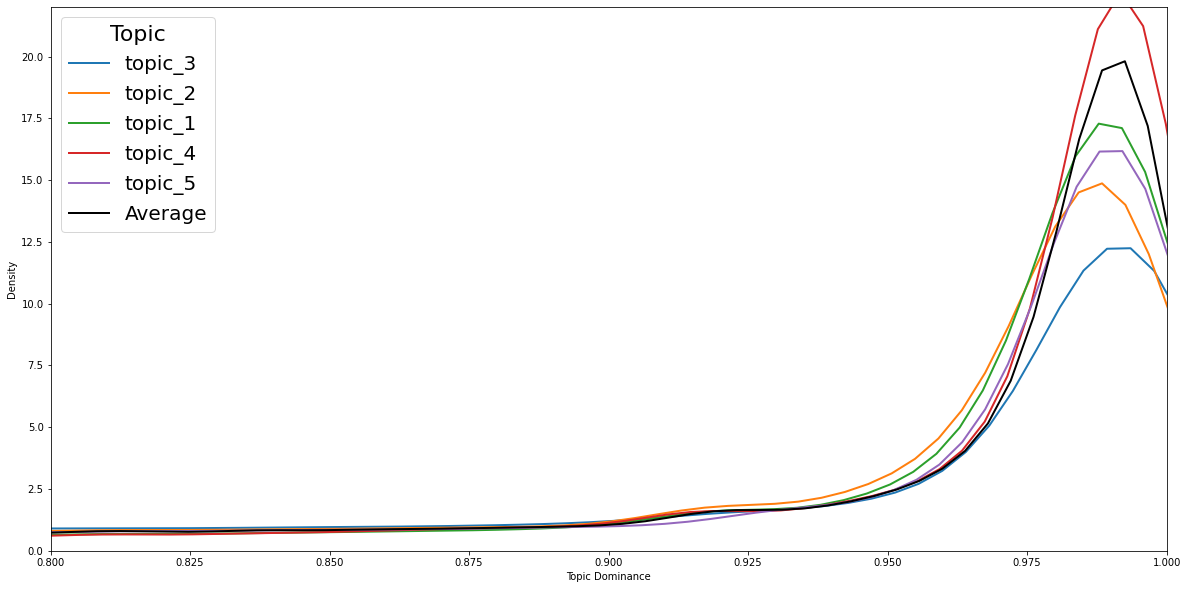

In [26]:
# !pip install seaborn
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

plt.figure(figsize=(20,10))

a = final_df_renamed_cols.groupby('lda_dominant')

# Iterate through the five topics
topics = [topic for topic in final_df_renamed_cols['lda_dominant'].unique() if isinstance(topic, str)]

for topic in topics:
    b = a['lda_dominant_score'].get_group(topic)

    #     b.plot.density(color='green')
    # plt.title('Density plot for Speeding')
    # plt.show()

    sns.distplot(b, hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = topic)
    
# Plot formatting
sns.distplot(final_df_renamed_cols['lda_dominant_score'], hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 color = 'black',
                 label = 'Average')

plt.legend(prop={'size': 20}, title = 'Topic', title_fontsize=22)
# plt.title('Score Density of the dominant topics grouped by topic', fontsize=24)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.xlabel('Topic Dominance')
plt.ylim(0, 22)
plt.xlim(0.8, 1)
plt.ylabel('Density')

# EXTRAS

## Training Multiple LDA Models

In [ ]:
TOPIC_SELECTION = range(2,21, 1)
list(TOPIC_SELECTION)


%%time

paragraphs = result.merged_POS
# MIN_DF = 0.1
# MAX_DF = 0.8

# Vectorization
# dictionary, corpus = vectorize(paragraphs, MIN_DF=MIN_DF, MAX_DF=MAX_DF)

models = compare_lda_models(OUTPUT_DIR='../../../../../data/clean/lda_models/50k_paragraphs/', TOPIC_SELECTION=TOPIC_SELECTION,
                LEMMATIZED_TEXT=paragraphs, DICTIONARY=dictionary, CORPUS=corpus, MIN_DF=MIN_DF, MAX_DF=MAX_DF, N_ITERATIONS=1000,
                PATH_TO_MALLET=r'C:/mallet/bin/mallet.bat', GET_COHERENCE_SCORE=True, COHERENCE='c_v')

## Load Multiple LDA Models